## 1. Creating Embeddings

In [39]:
import csv
import json
import numpy as np
import seaborn as sns
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

# Read classmates and their responses from a CSV file, replace classmates.csv with own link or file name
attendees_map = {}
with open('classmates.csv', newline='') as csvfile:
    classmates = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(classmates)  # Skip the header row
    for row in classmates:
        name, paragraph = row
        attendees_map[paragraph] = name
        
# Generate sentence embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
paragraphs = list(attendees_map.keys())
embeddings = model.encode(paragraphs)
    
# Create a dictionary to store embeddings for each person
person_embeddings = {attendees_map[paragraph]: embedding for paragraph, embedding in zip(paragraphs, embeddings)}

# Save dictionary to file
person_embeddings = {key: value.tolist() for key, value in person_embeddings.items()} # Convert numpy arrays to lists

with open("embeddings.json", "w") as f:
    json.dump(person_embeddings, f)

## 2. Creating Visualization

In [67]:
# Reducing dimensionality of embedding data, scaling to coordinate domain/range
import umap
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import spearmanr, kendalltau
import optuna

myKey = "Priya Singh" # using Priya Singh from the GPT generated data for this exercise - ideally students would compute correlations wrt to every point in the dataset, not just one

# Compute cosine similarity and return list of names sorted by it
def cosine_names():

    myVal = person_embeddings[myKey]

    similarity = []
    for key, value in person_embeddings.items():
        thisSimilarity = 1 - cosine(value, myVal)
        similarity.append((key, thisSimilarity))

    similarity.sort(key=lambda x: x[1], reverse=True)
    names = [x[0] for x in similarity]

    return names

# Compute distances in visualization and return names sorted by it
def distance_names(distance_data):
    
    keys = list(person_embeddings.keys())
    myCoords = distance_data[keys.index(myKey)]

    distances = [euclidean(myCoords, p) for p in distance_data]
    
    pairs = list(zip(keys, distances))
    pairs.sort(key=lambda x: x[1])
    names = [x[0] for x in pairs]

    return names

# Compute rank correlation
def rank_correlation(distance_data):

    names1 = cosine_names()
    names2 = distance_names(distance_data)

    rank1 = list(range(1, len(names1)+1))
    rank2 = []
    for i in range(len(rank1)):
        rank2.append(names2.index(names1[i])+1)

    spearman_corr, spearman_p = spearmanr(rank1, rank2)
    #print(f"Spearman's rank correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

    return spearman_corr

def objective(trial):
    this_n_neighbors = trial.suggest_int('this_n_neighbors', 2, 6)
    this_min_dist = trial.suggest_float('this_min_dist', 0, 0.99)

    reducer = umap.UMAP(random_state=42, metric='cosine', n_neighbors=this_n_neighbors, min_dist=this_min_dist) # set the seed to 42
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(list(person_embeddings.values()))
    this_reduced_data = reducer.fit_transform(scaled_data)

    min_fun = -rank_correlation(this_reduced_data) # maximize correlation, so function to minimize is negative of correlation

    return min_fun

study = optuna.create_study()
study.optimize(objective, n_trials=20)

study.best_params

#run UMAP with best_params
reducer = umap.UMAP(random_state=42, metric='cosine', n_neighbors=study.best_params['this_n_neighbors'], min_dist=study.best_params['this_min_dist']) # set the seed to 42
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(person_embeddings.values()))
this_reduced_data = reducer.fit_transform(scaled_data)

[I 2023-06-30 20:58:27,934] A new study created in memory with name: no-name-67e11091-760b-4e3a-8639-c35a2427eee1
[I 2023-06-30 20:58:29,597] Trial 0 finished with value: -0.24812030075187969 and parameters: {'this_n_neighbors': 2, 'this_min_dist': 0.0006918986834888563}. Best is trial 0 with value: -0.24812030075187969.
[I 2023-06-30 20:58:31,061] Trial 1 finished with value: -0.5037593984962406 and parameters: {'this_n_neighbors': 4, 'this_min_dist': 0.3869153066627407}. Best is trial 1 with value: -0.5037593984962406.
[I 2023-06-30 20:58:32,482] Trial 2 finished with value: -0.2270676691729323 and parameters: {'this_n_neighbors': 3, 'this_min_dist': 0.5352264668447632}. Best is trial 1 with value: -0.5037593984962406.
[I 2023-06-30 20:58:34,215] Trial 3 finished with value: -0.39097744360902253 and parameters: {'this_n_neighbors': 5, 'this_min_dist': 0.1328693579528861}. Best is trial 1 with value: -0.5037593984962406.
[I 2023-06-30 20:58:35,675] Trial 4 finished with value: -0.4872

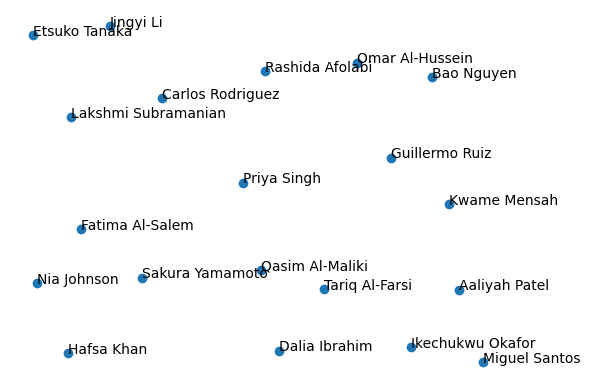

In [68]:
import matplotlib.pyplot as plt

# Creating lists of coordinates with accompanying labels
x = [row[0] for row in reduced_data]
y = [row[1] for row in reduced_data]
label = list(person_embeddings.keys())

# Plotting and annotating data points
plt.scatter(x,y)
for i, name in enumerate(label):
    plt.annotate(name, (x[i], y[i]), fontsize="10")

# Clean-up and Export
plt.axis('off')
plt.savefig('visualization.png', dpi=800)


## 3. [BONUS] Providing top matches

In [4]:
from collections import defaultdict

In [5]:
top_matches = {}
all_personal_pairs = defaultdict(list)
for person in attendees_map.values():
    for person1 in attendees_map.values():
        all_personal_pairs[person].append([spatial.distance.cosine(person_embeddings[person1], person_embeddings[person]), person1])

for person in attendees_map.values():
    top_matches[person] = sorted(all_personal_pairs[person], key=lambda x: x[0])

print(top_matches)


{'Aaliyah Patel': [[0, 'Aaliyah Patel'], [0.5672373713402337, 'Kwame Mensah'], [0.708439911116006, 'Guillermo Ruiz'], [0.727201088562308, 'Carlos Rodriguez'], [0.7395498282946303, 'Qasim Al-Maliki'], [0.7760088295898687, 'Ikechukwu Okafor'], [0.8057684017092718, 'Bao Nguyen'], [0.8194445424598251, 'Hafsa Khan'], [0.8326146454730058, 'Dalia Ibrahim'], [0.8413415106748103, 'Lakshmi Subramanian'], [0.8444181073715983, 'Miguel Santos'], [0.852658656956724, 'Omar Al-Hussein'], [0.8600731600583584, 'Priya Singh'], [0.882059836131701, 'Fatima Al-Salem'], [0.8969501738340095, 'Nia Johnson'], [0.9356908245303076, 'Etsuko Tanaka'], [0.9446181027293437, 'Sakura Yamamoto'], [0.9620888190108263, 'Tariq Al-Farsi'], [0.9717902389006675, 'Jingyi Li'], [0.9828171846433728, 'Rashida Afolabi']], 'Bao Nguyen': [[0, 'Bao Nguyen'], [0.6620322793565447, 'Guillermo Ruiz'], [0.6832200181341426, 'Omar Al-Hussein'], [0.7100531554649215, 'Kwame Mensah'], [0.7359562247682364, 'Qasim Al-Maliki'], [0.803983143369297